##  a mixture of experts（**MoE**）:架构优势（Deepseek）
 - 图片左侧的是最基本的transformer架构，而右侧的是MoE架构
 - MoE有几个专家子组件，这些组件是稀疏激活的，只有一个地方不一样，也就是把FFN进行复制和分割（取决于如何设置你的MOE）,再通过一个选择器选择小的网络来通过，这就是稀疏激活
 - 在相同的训练中，MoE可以获得更好的性能
 - 更多的experts可以带来更低的loss,但是也会有更大的性能消耗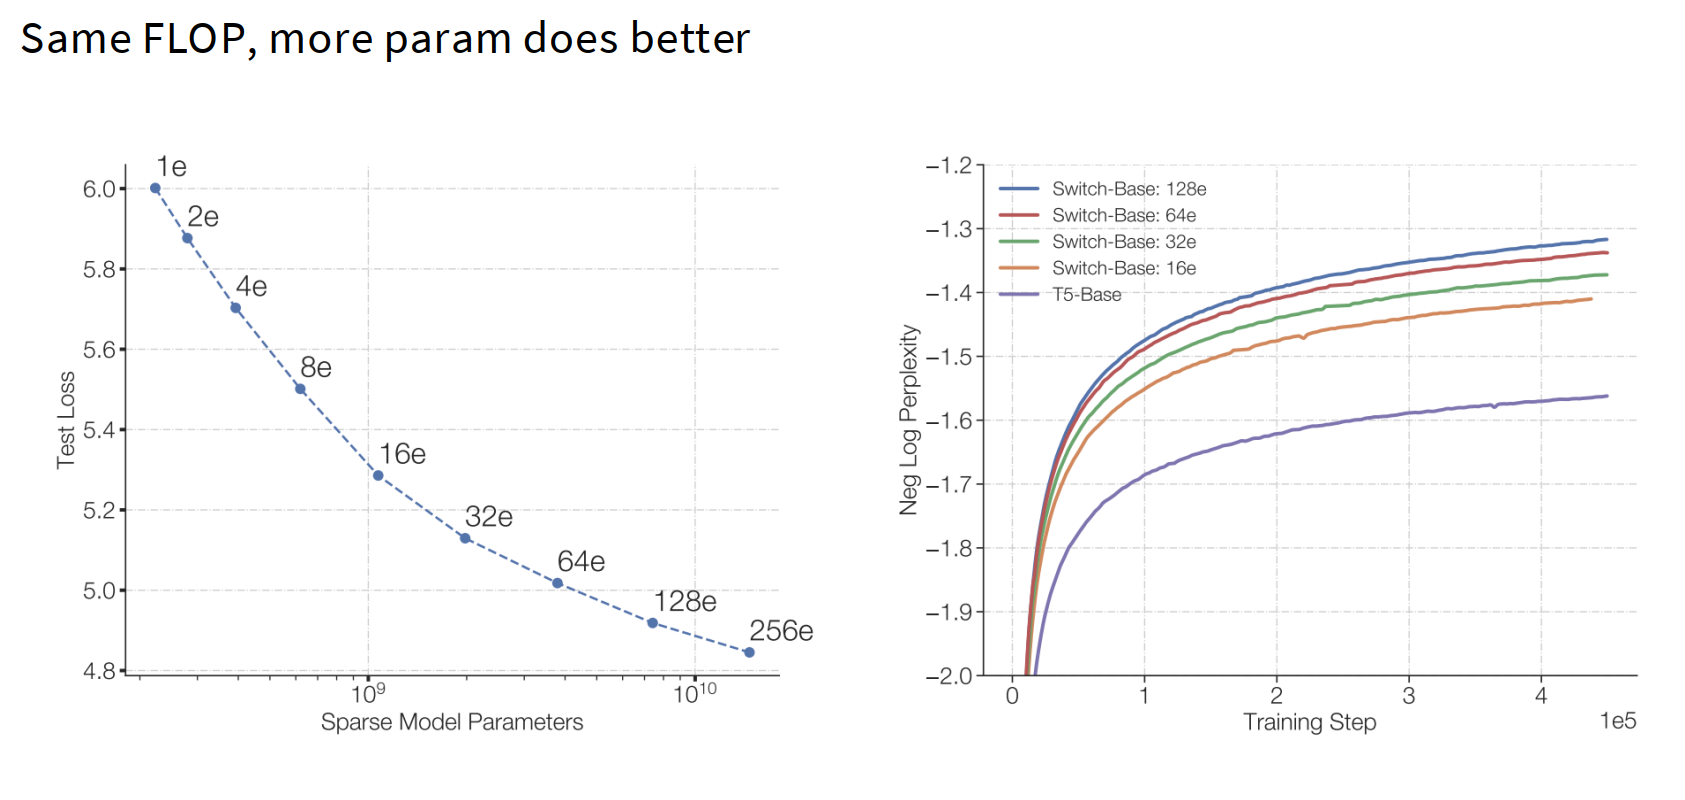
 - MoE架构和非MoE架构在几乎所有的组件上都是相似的
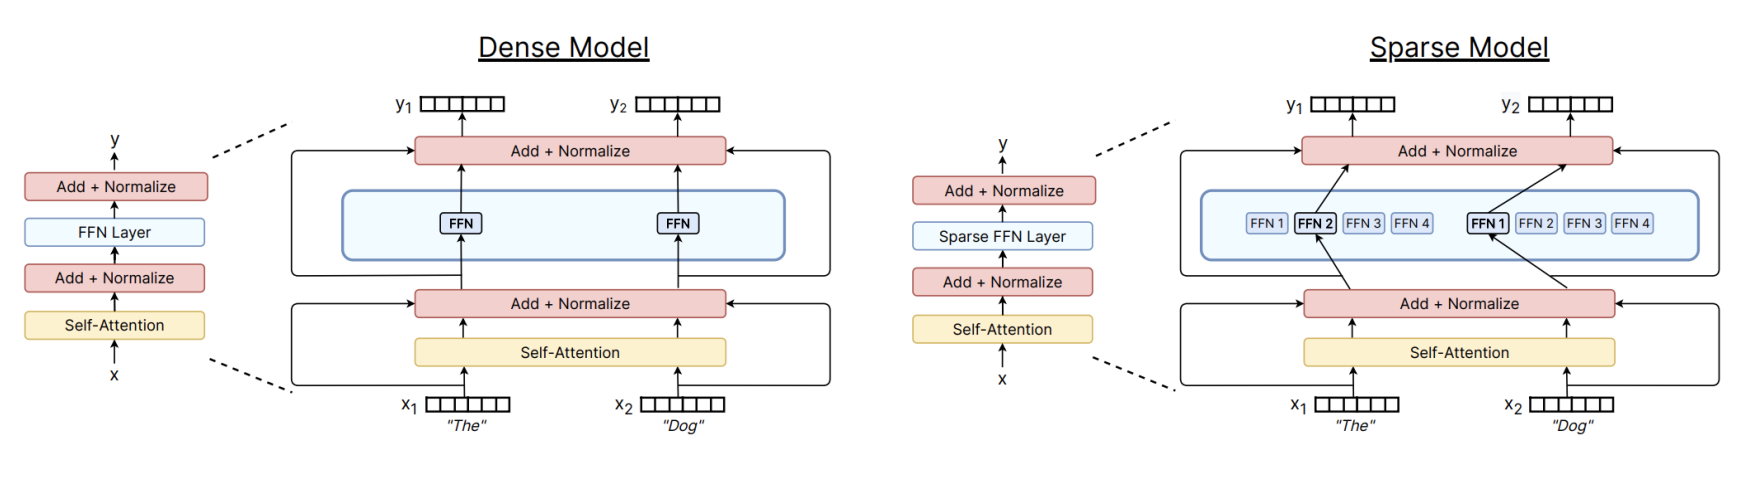


### MoE的另一个优势：提供并行化的另一种可能：可以把不同的expert放在不同的机器上
 - 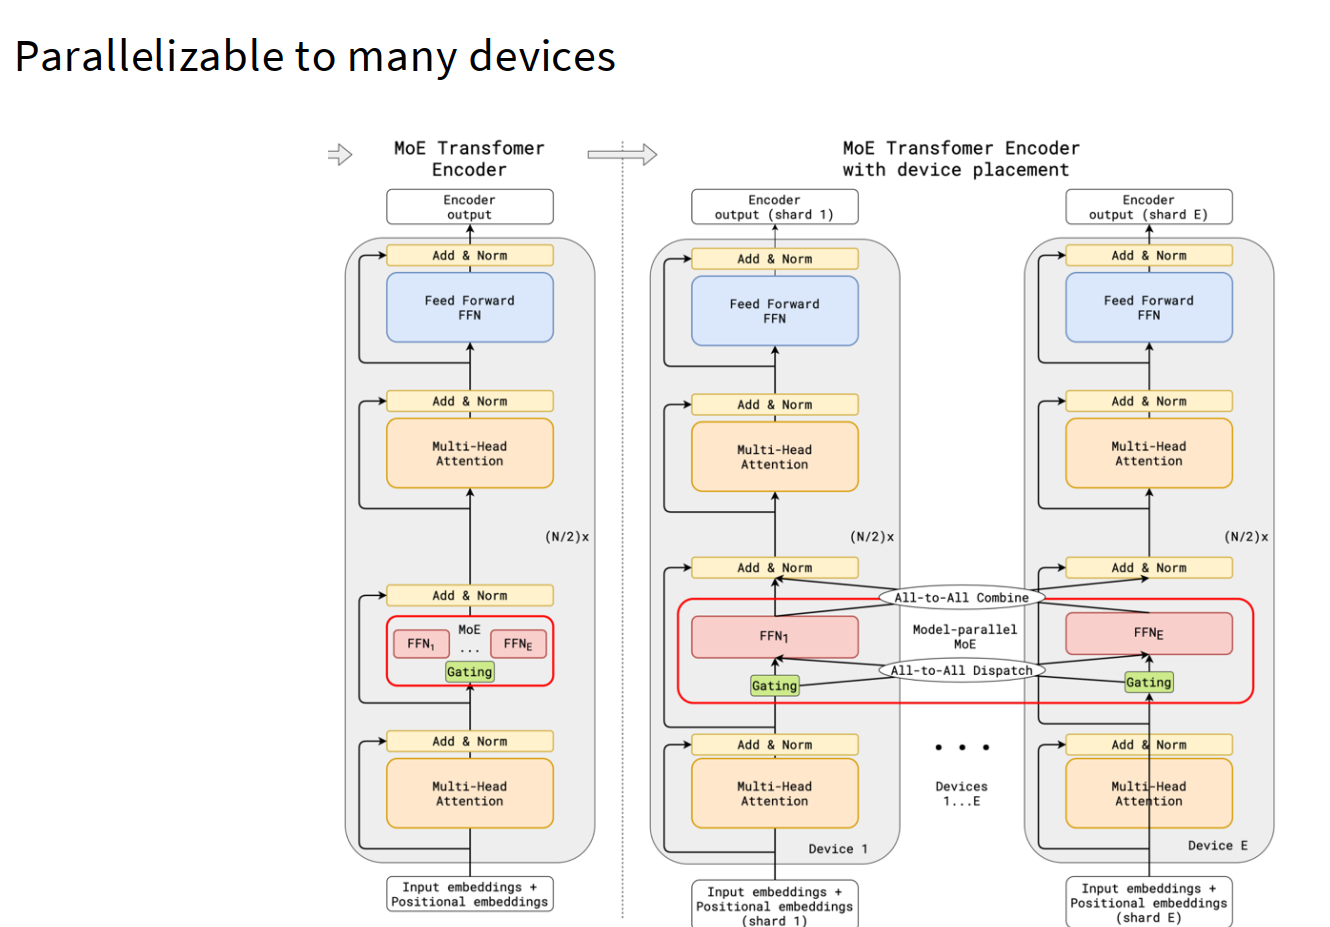
##### 几种并发的形式：可以权衡使用最大化你的机器的内存和性能
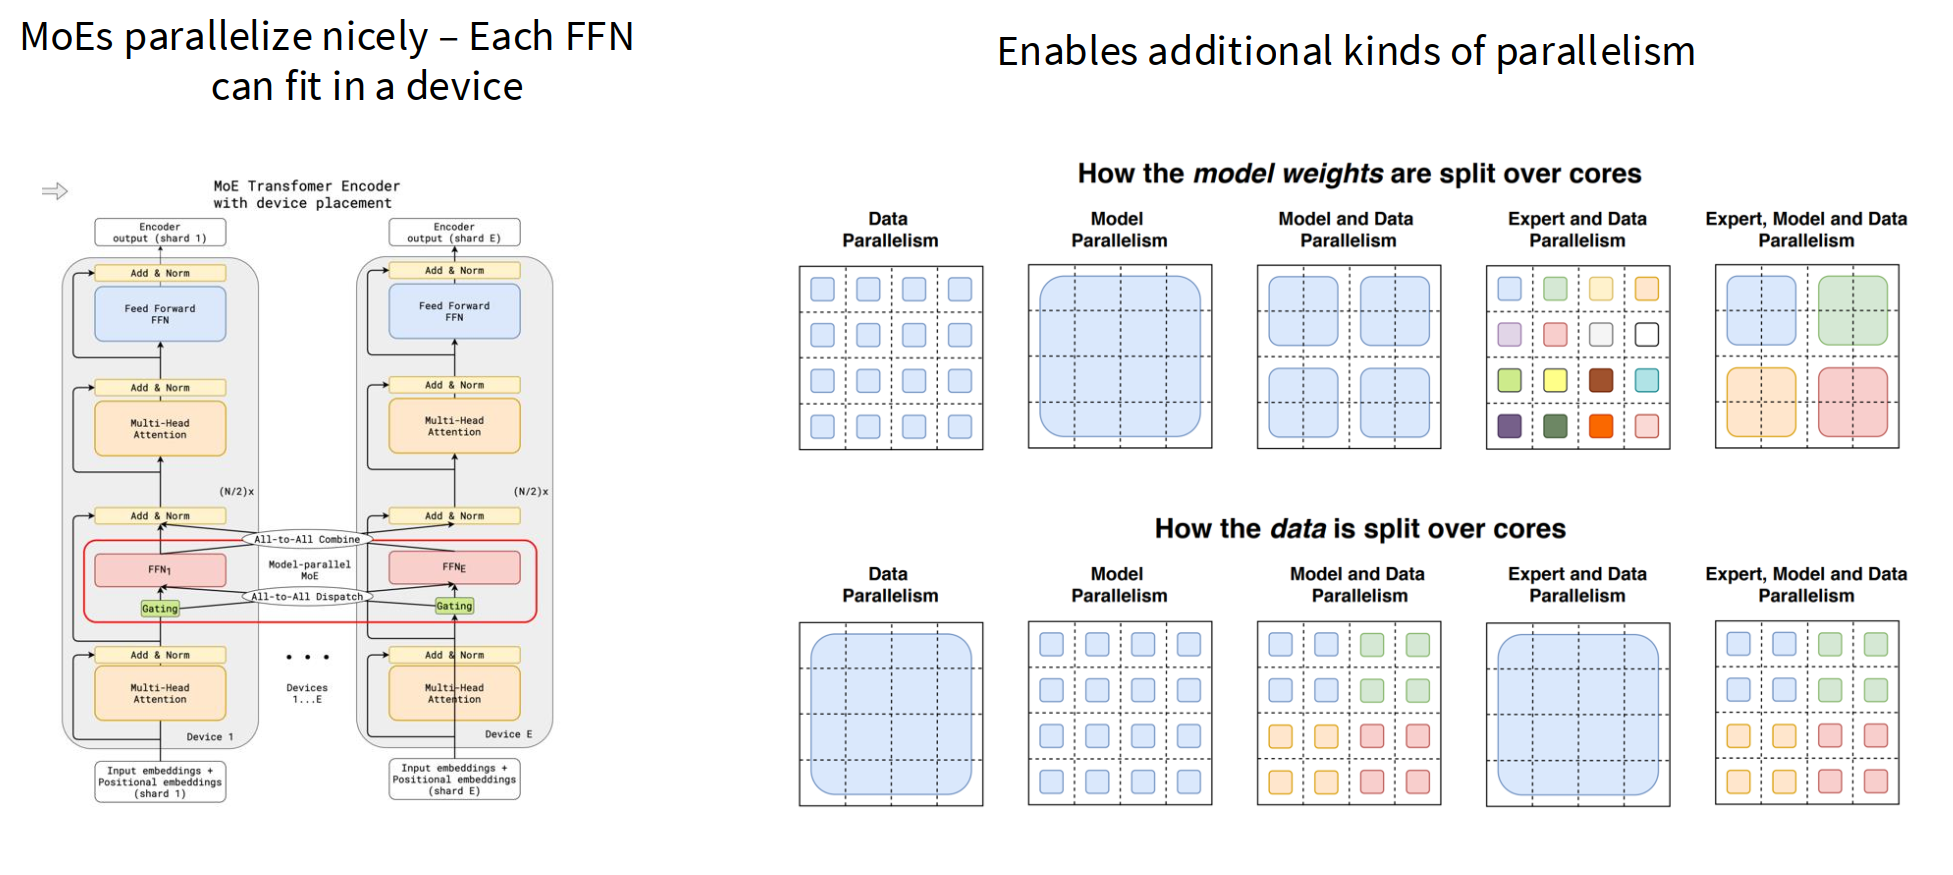4
 - 可以在一个GPU上配置一个或多个experts(因为只需要进行小矩阵的稀疏乘法)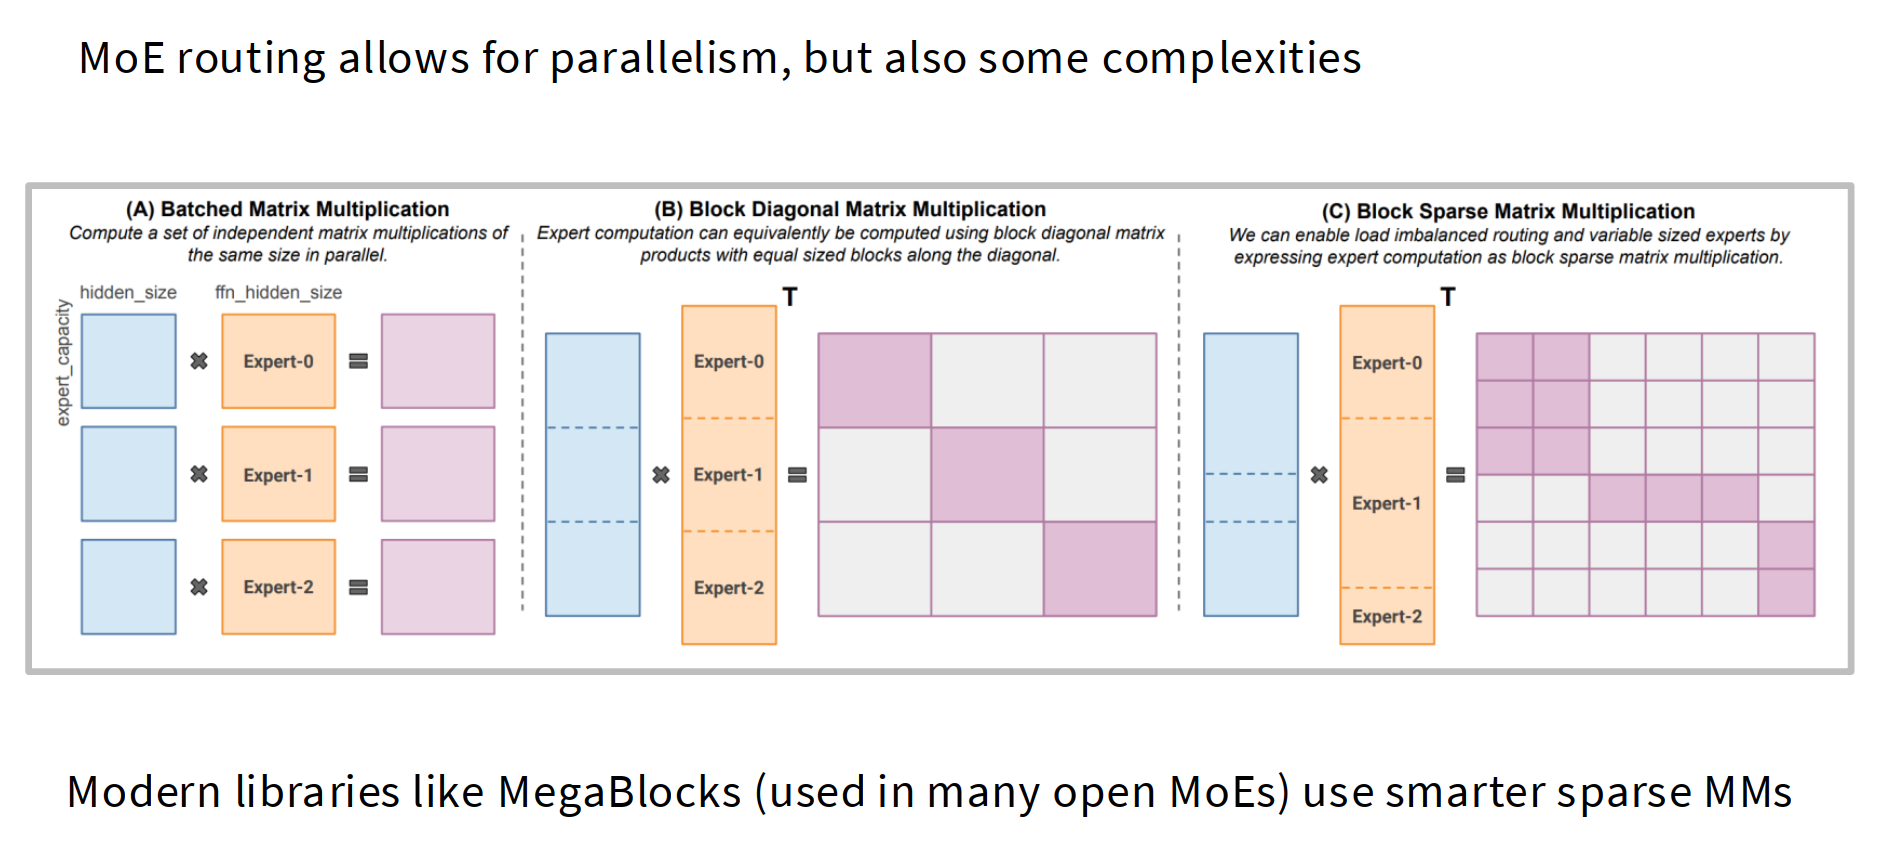
 - 如果一个batch的所有token都到一个GPU上的expert上了，那么这个GPU的内存可能就会不够用——下面就会进行token dropping(丢弃)，在training/Infer时候都会发生，所以在同样的进行training的时候，有可能每次得到的结果就不一样，因为token dropping是有一定的随机性的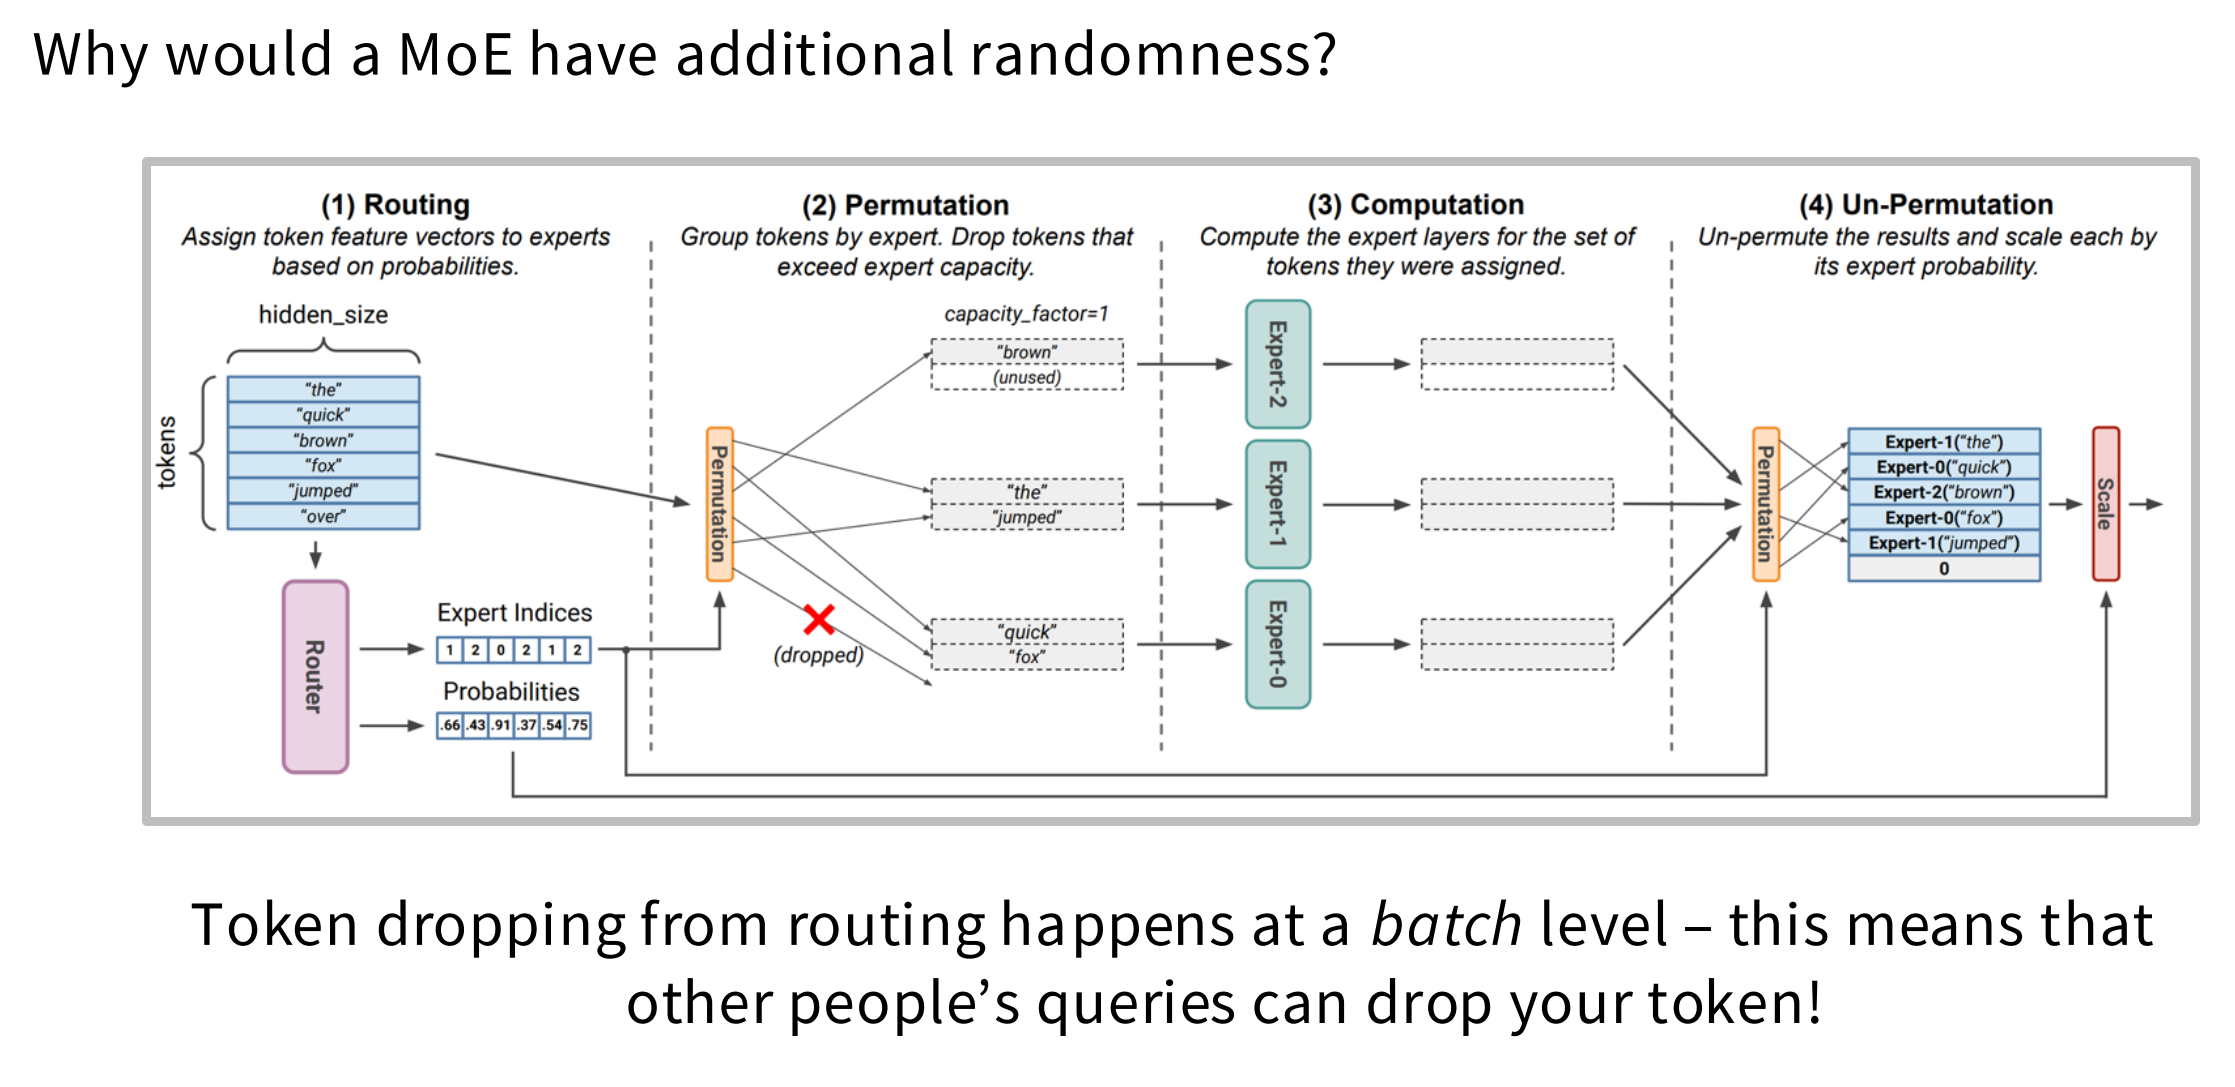



#### MoE - what varis?
 - Routing function
 - Expert sizes
 - Training objectives

#### **Routing function - moving tokens to experts**
Many of the routing algorithms(路由决策) boil down to 'choose top k（一般大于2）'
##### Token choose experts
每个令牌独立选择最适合处理它的 k 个专家，但可能导致专家负载不均衡
##### expert choose token
专家根据其处理能力和负载，主动选择要处理的令牌，以实现负载均衡
##### global routing via optimization
通过一个全局目标函数来最小化成本并最大化性能，寻找最优的整体令牌-专家分配方案
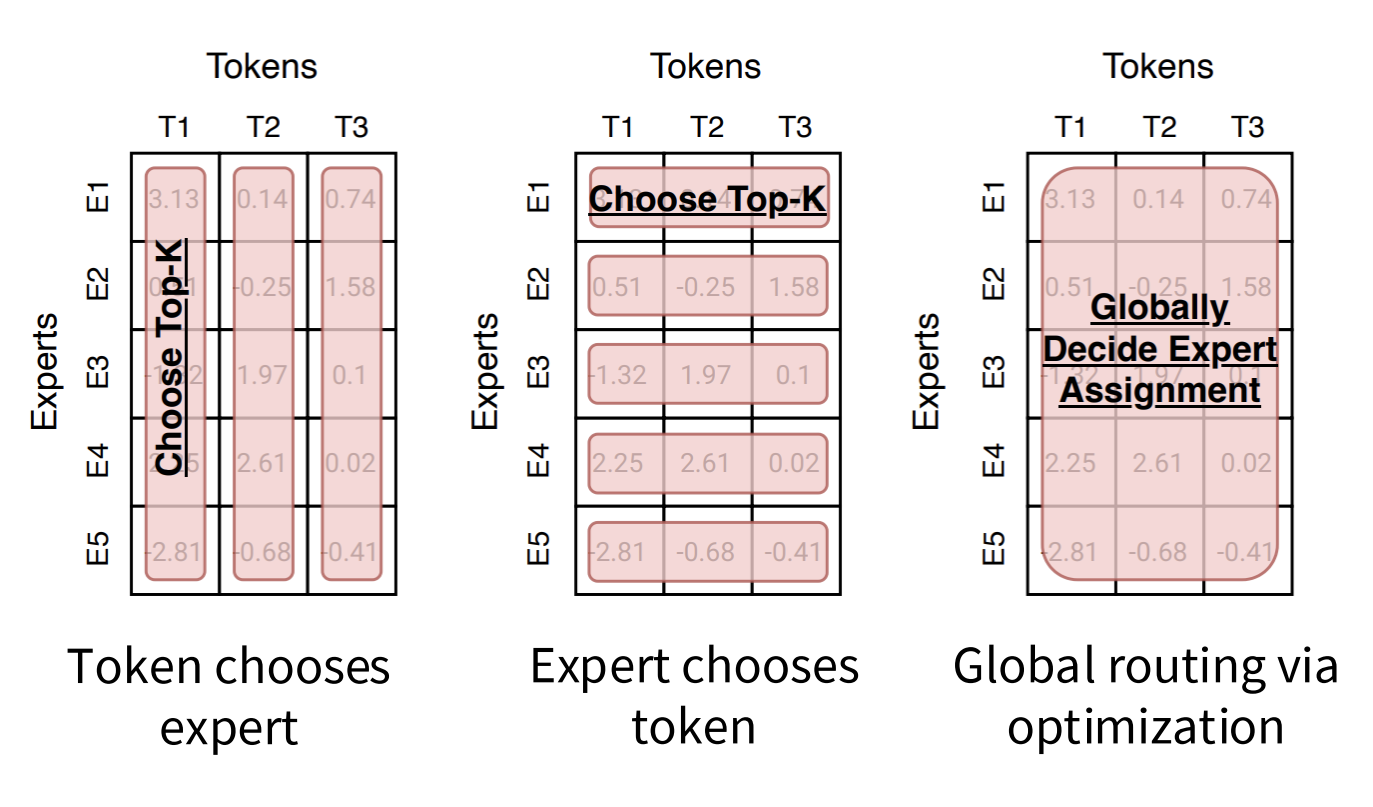

#### Common routing variants in detail
 - 有些论文甚至标识不需要用到路由器，而仅仅只需要用hash函数替代即可（这样每一个专家也可以获得一个确定性的token子集，其中也有specialization），即使哈希函数完全没有语义信息，MoE也可以从中获益
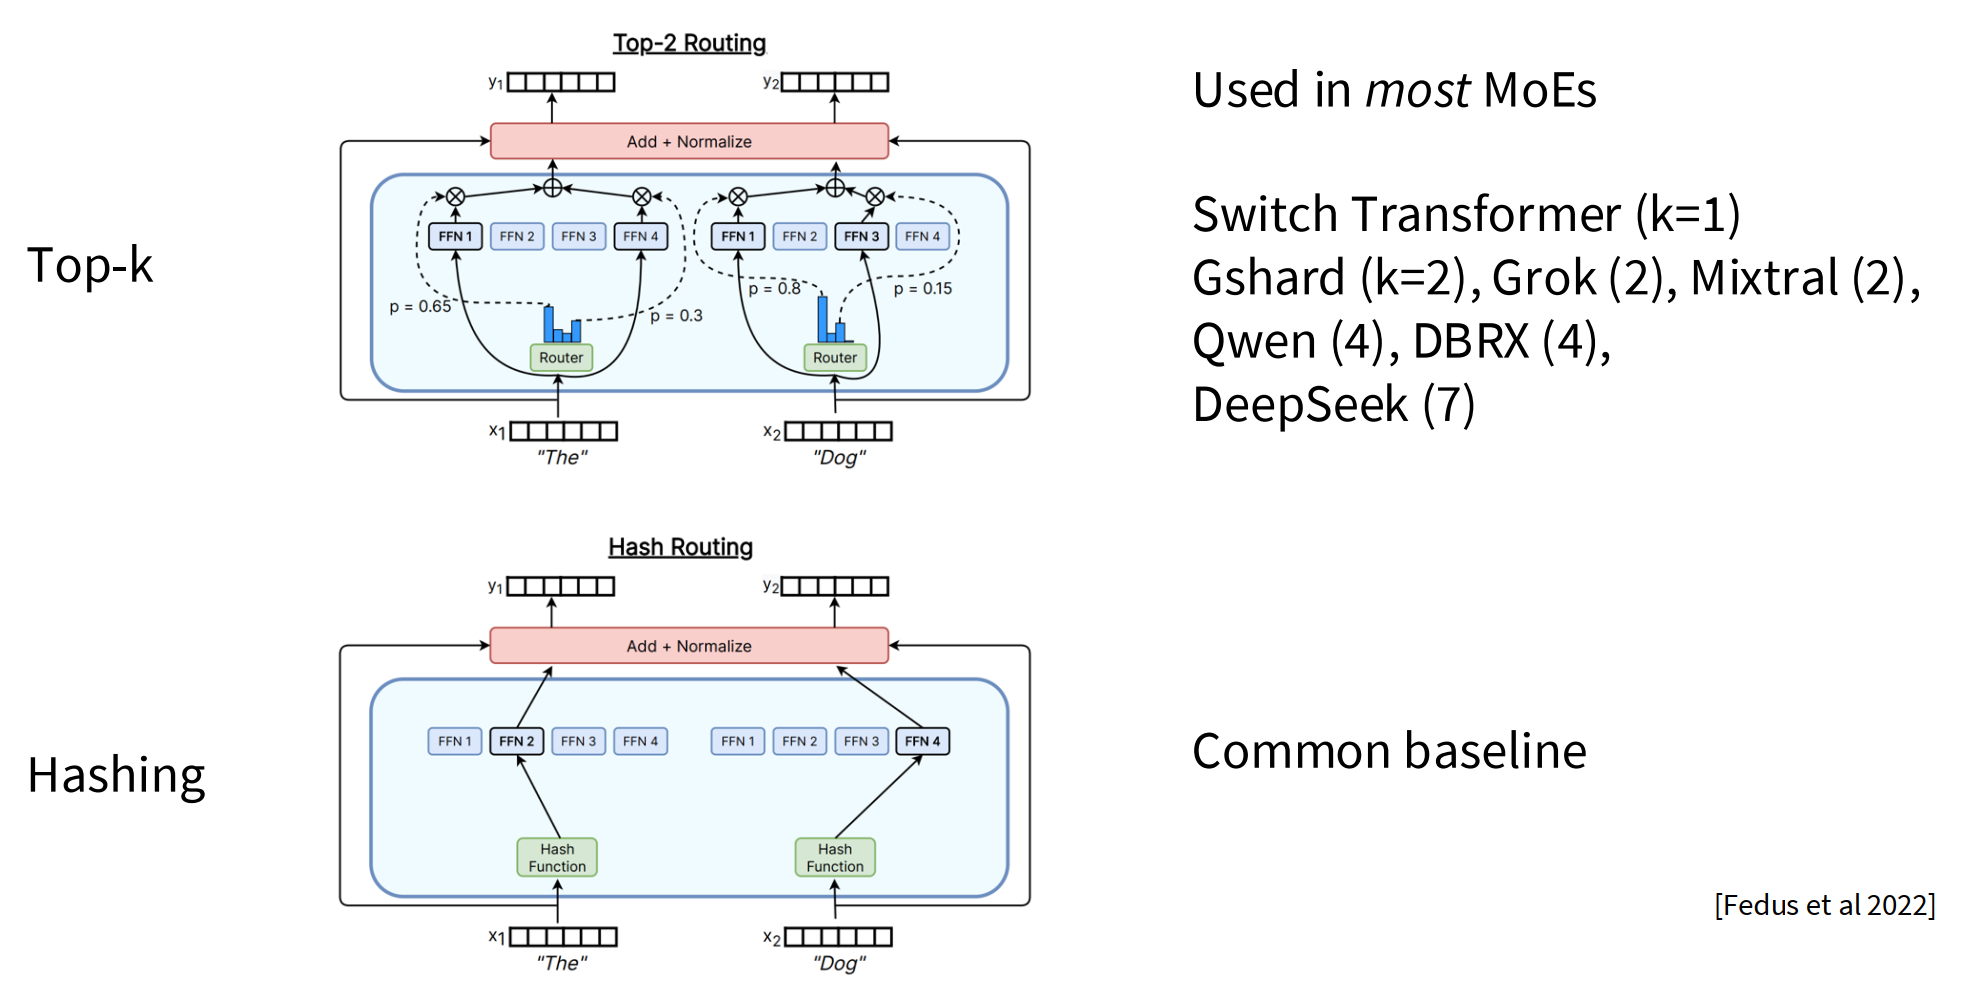
 - 也可以通过强化学习来学习routing函数（因为这个是discrete desicion,非常适合强化学习去处理），但是成本过高，而且稳定性降低

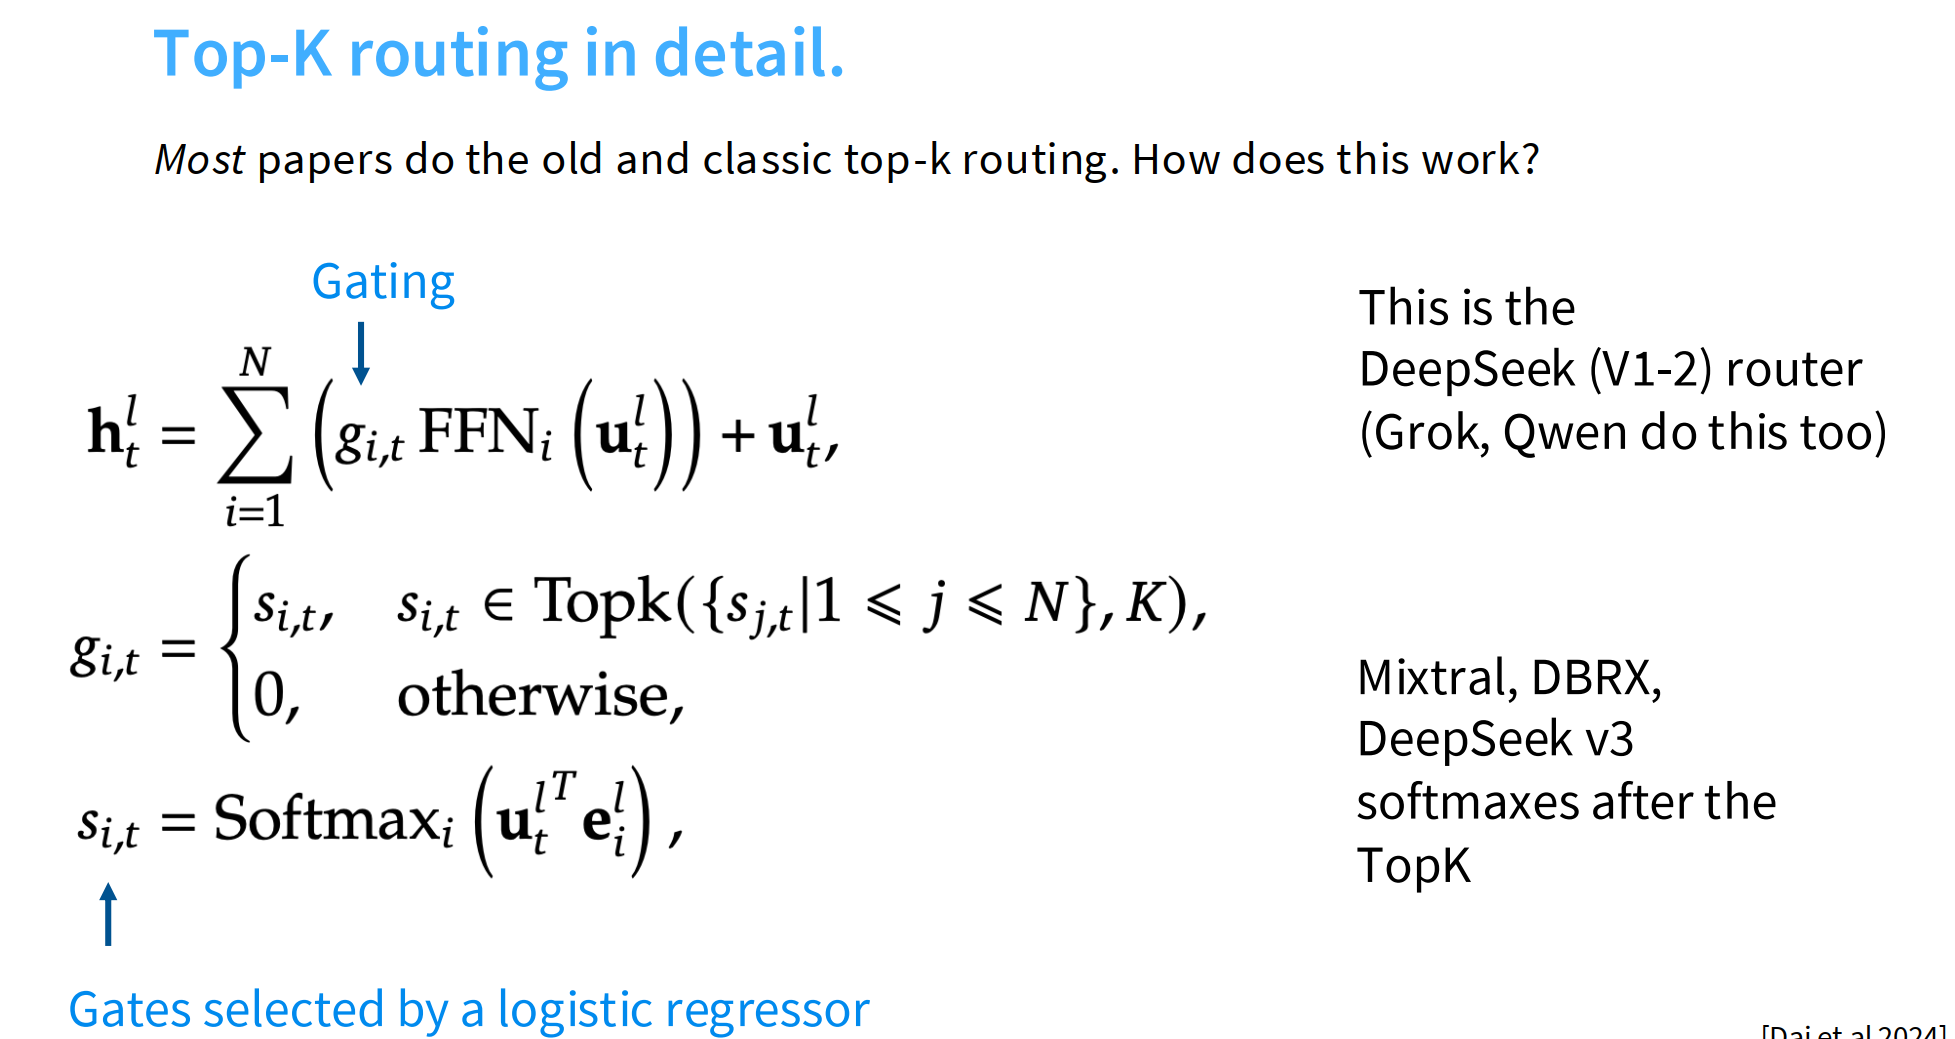
### “Top-K”路由（Top-K Routing）机制详解——如何拥有稀疏数量的激活experts

#### 符号解释

* $t$：当前处理的令牌（token）。
* $l$：当前所在的网络层（layer）。
* $\mathbf{h}_{t}^{l}$：第 $l$ 层第 $t$ 个令牌的输出表示。
* $N$：可用的专家总数。
* $k$：在“Top-K”路由中，为每个令牌选择的专家数量。
* $i$：专家的索引，从 1 到 $N$。
* $g_{i,t}$：一个门控函数（gating function）的输出，用于决定第 $t$ 个令牌是否由第 $i$ 个专家处理。如果被选中，其值为专家选择分数 $s_{i,t}$；否则为 0。
* $\text{FFN}_{i}$：第 $i$ 个专家的前馈网络（Feed-Forward Network）。
* $\mathbf{u}_{t}^{l}$：第 $l$ 层第 $t$ 个令牌的输入表示。
* $s_{i,t}$：第 $t$ 个令牌由第 $i$ 个专家处理的选择分数。
* $\text{Topk}(\{s_{j,t}|1 \leq j \leq N\}, K)$：从所有专家的选择分数 $\{s_{j,t}\}$ 中，选出分数最高的 $K$ 个。
* $\text{Softmax}_{i}$：对所有专家的选择分数进行 Softmax 操作，使其总和为 1。
* $\mathbf{e}_{i}^{l}$：第 $l$ 层中与第 $i$ 个专家关联的可学习权重向量（通常是一个线性回归器，也称为门控网络）,**其实可以看做expert的parameters**。

#### 整体思路

这套公式描述了一个经典的 Top-K 路由机制，其核心思想是为每个输入令牌**动态地选择最相关的 K 个专家**来处理它。

1.  **计算专家分数（Gating Scores）**：对于每一个令牌 $\mathbf{u}_{t}^{l}$，模型首先通过一个门控网络（logistic regressor），使用 Softmax 函数计算出它与每一个专家 $\mathbf{e}_{i}^{l}$ 的匹配分数 $s_{i,t}$。这个分数代表了每个专家处理该令牌的“相关性”或“潜力”。

2.  **选择 Top-K 专家**：接下来，模型会从所有专家的分数 $\{s_{j,t}\}$ 中，选择分数最高的 $K$ 个。那些未被选中的专家，其门控值 $g_{i,t}$ 被设为 0。被选中的专家则保留其分数。

3.  **计算加权和**：最后，模型将这 $K$ 个被选中的专家处理结果进行加权求和，得到最终的输出 $\mathbf{h}_{t}^{l}$。这里的权重就是前面计算出的分数 $g_{i,t}$。这种加权平均确保了令牌的输出是由最相关的专家共同贡献的。

**整体流程**可以概括为：**令牌输入 -> 门控网络计算分数 -> 选择 Top-K 专家 -> 专家并行处理 -> 加权求和得到输出**。



### 不想为更多的专家提供更多的参数 —— 把experts分割的更小而不是复制它们
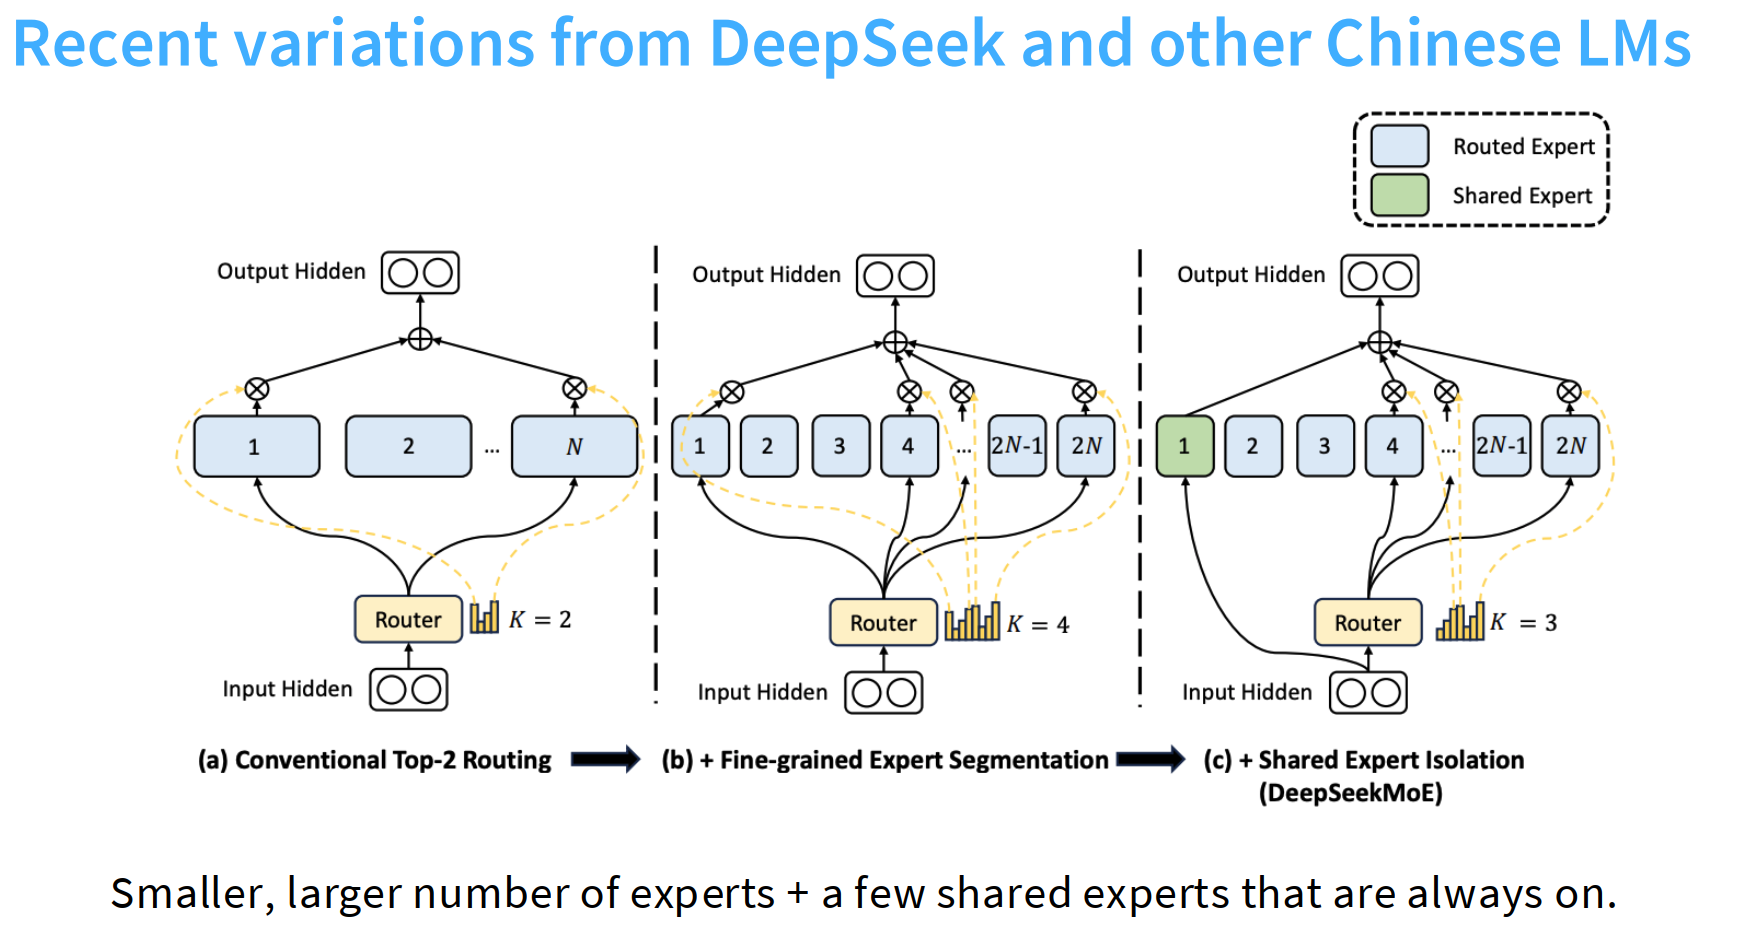
(a) 常规 Top-2 路由（Conventional Top-2 Routing）：

该方法采用了传统的“Top-2”路由策略，即从所有专家中选择两个最相关的专家进行计算。

输入经过路由器（Router）后，路由器选择 K=2 个专家来进行计算。通常，专家数量较小。

(b) 精细化专家划分（Fine-grained Expert Segmentation）：

这种方法对**专家进行了更精细的划分（而不是复制）**，可能在每个输入样本中使用更多的专家（在本图中是 K=4），但是这些专家不是每次都启用。通过这种方式，模型可以对不同类型的输入选择更多的专家，从而提高效率和表现。

这种方式的重点是<mark>细粒度的专家选择和划分</mark>。

(c) 共享专家隔离（Shared Expert Isolation, DeepSeekMoE）：

这种方法采用了“共享专家”的概念，其中某些专家是始终开启的，所有输入样本都可以使用这些共享的专家。这些共享专家与其他个别专家共同工作，用来解决各种任务。

在图中，K=3 表示选择了三个专家，其中包括一些共享专家，它们在每个输入上都会启用。
#### 更多的experts和共享专家的结合
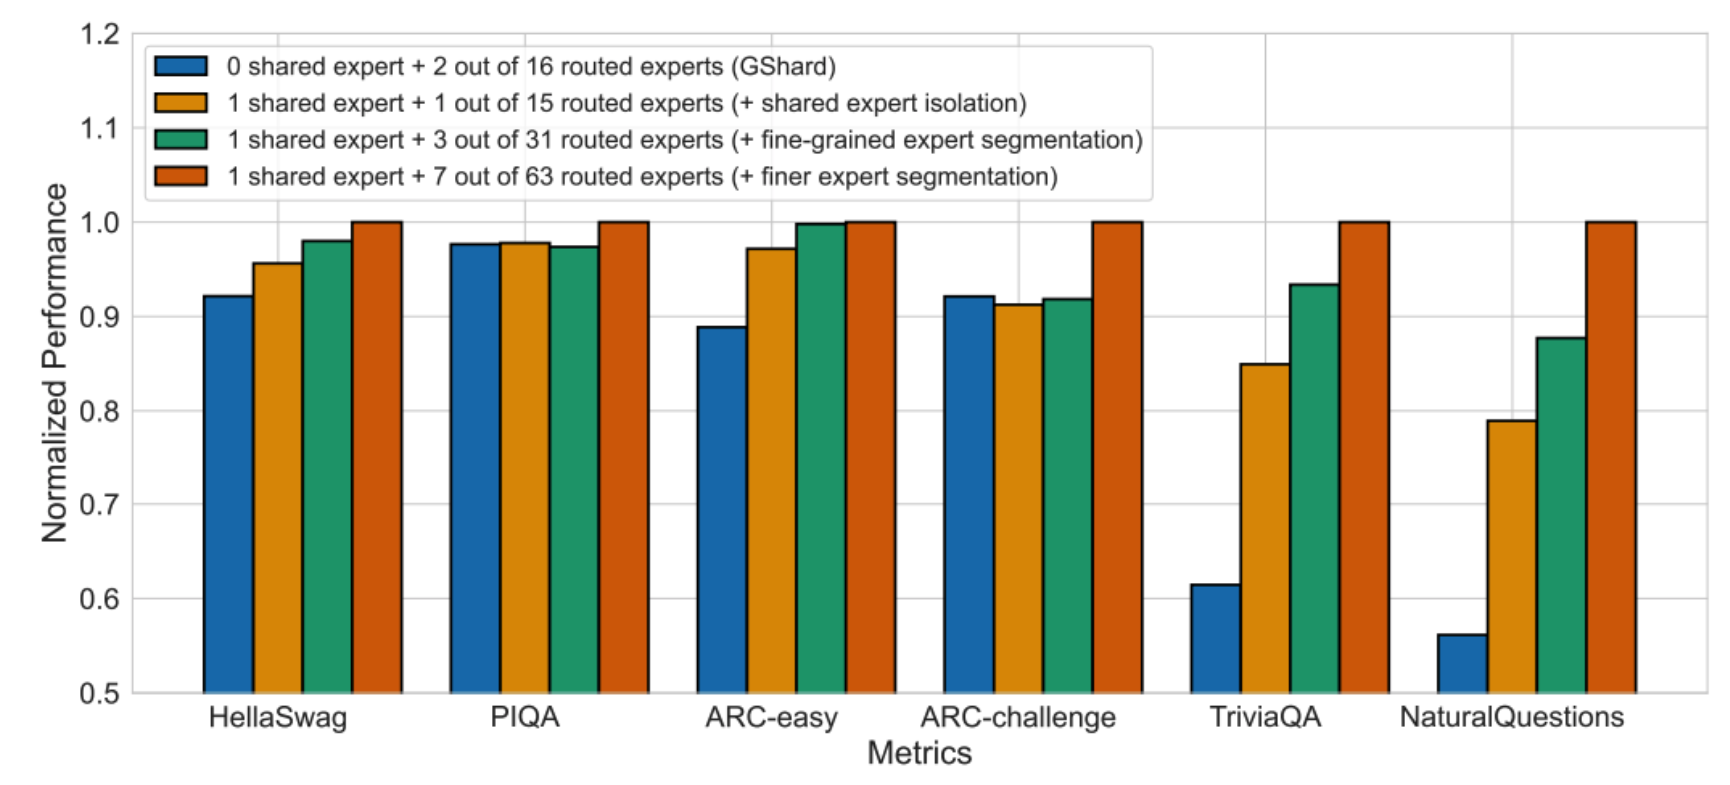

## How do we train MoEs?
Major challenge: we need sparsity for training-time efficiency…
But sparse gating decisions are not differentiable!
Solutions?
1. Reinforcment learning to optimize gating policies(成本太高)
2. Stochastic perturbations
3. Heuristic ‘balancing’ losses

#### Stochastic perturbations
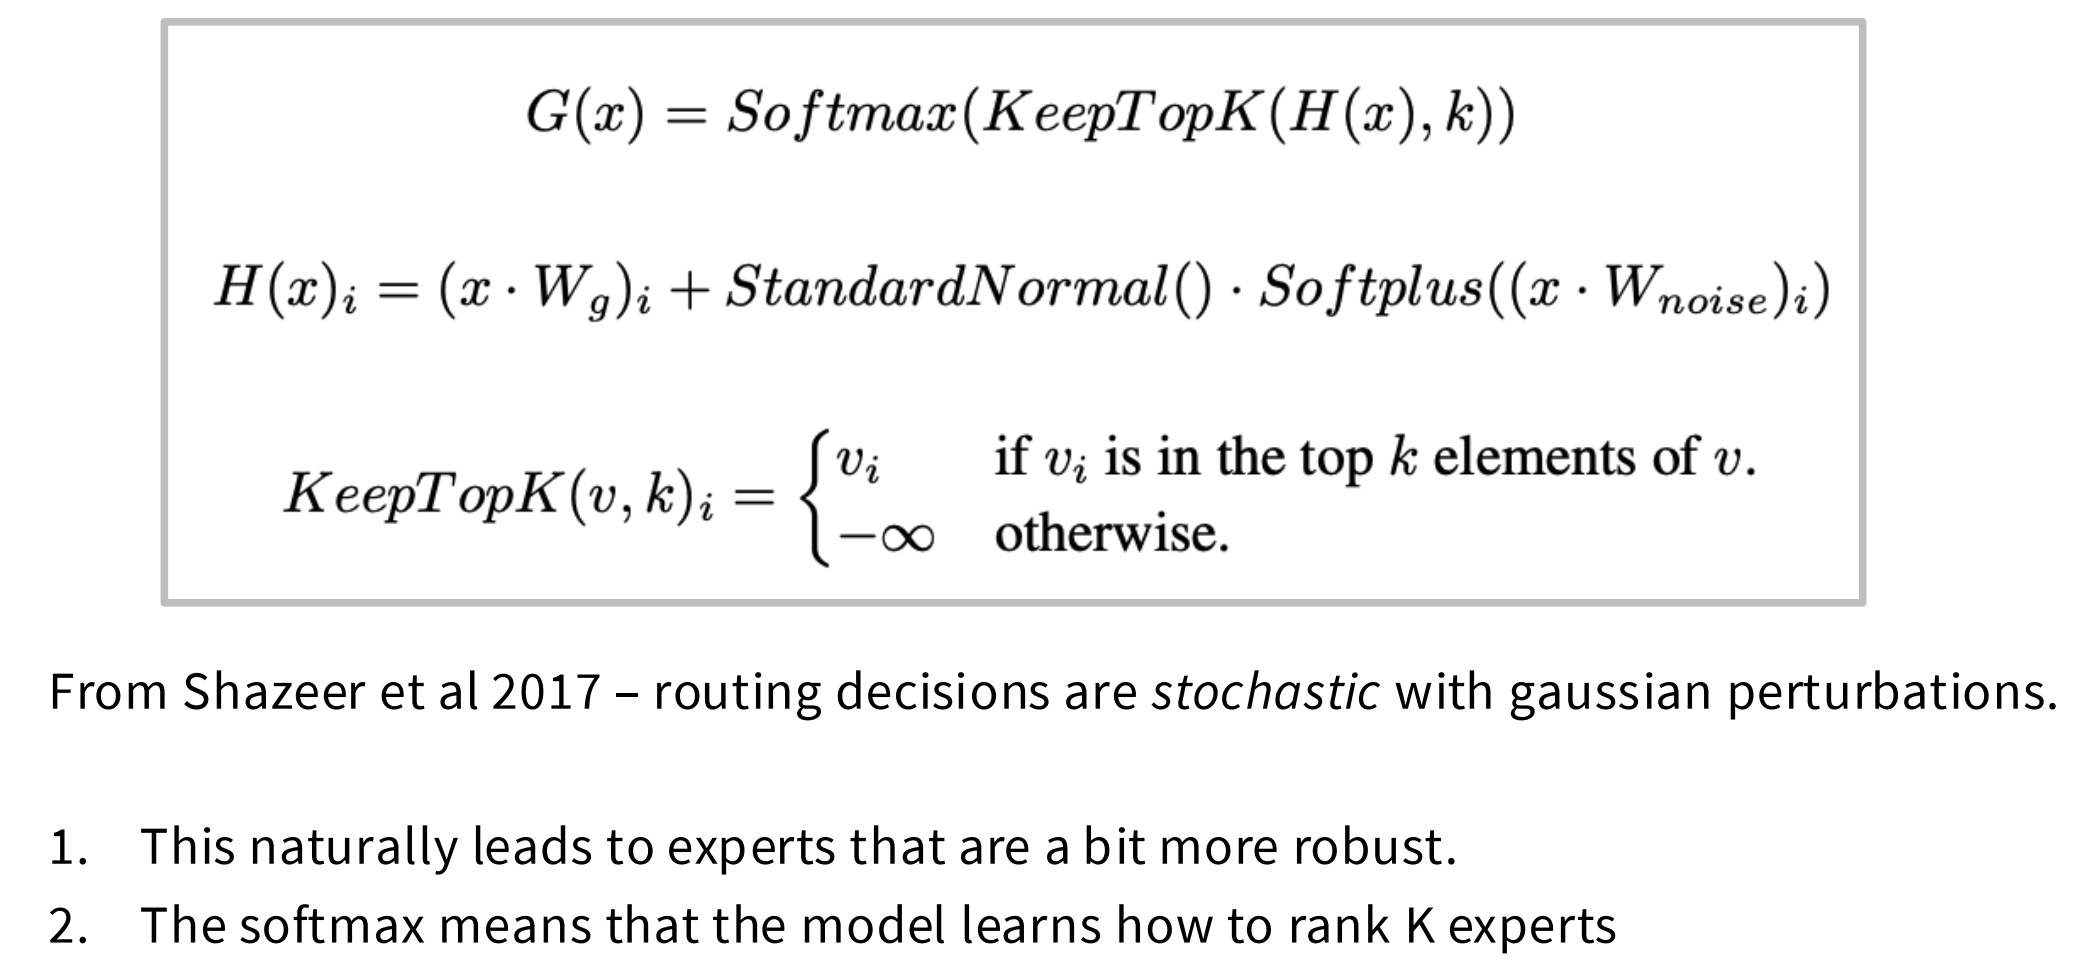
 - W noise scale that's learned(加一些随机初始化)
 - 对路由器逻辑施加一些乘性扰动

#### Heuristic balancing losses
 - 目前的问题是在训练初期有可能某一个expert精通所有的功能，而其他专家什么都不会，因为越被选择就学习得越多就越被选择的道理(local minimum)
 - 希望每一个batch都被平均分给每个专家（用到所有参数）
 - 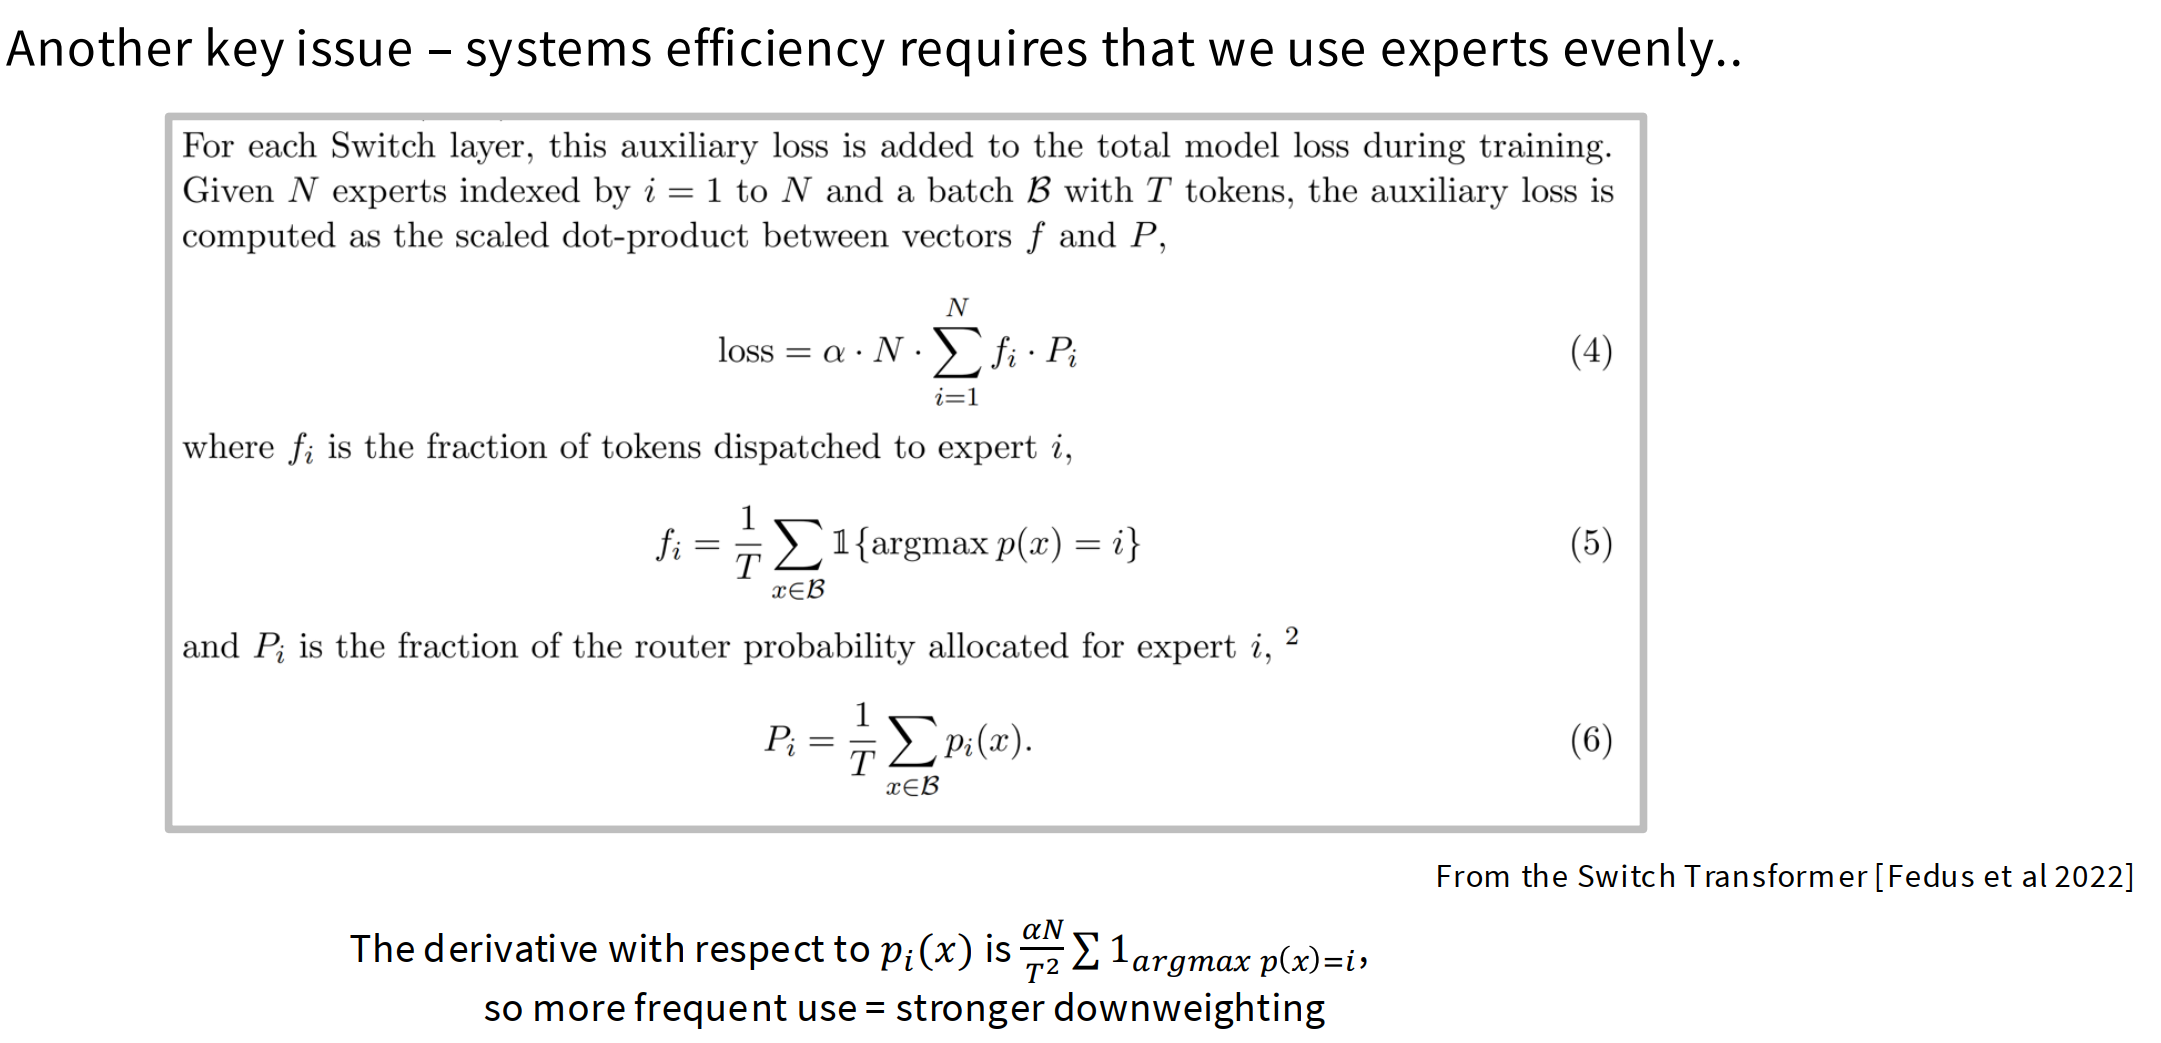
 - P是每个路由器预期得到的token的概率，f是实际的，通过这个（使用内积）来平衡各个expert的能力值
 - 其他一些变体<mark>auxiliary loss free balancing</mark>
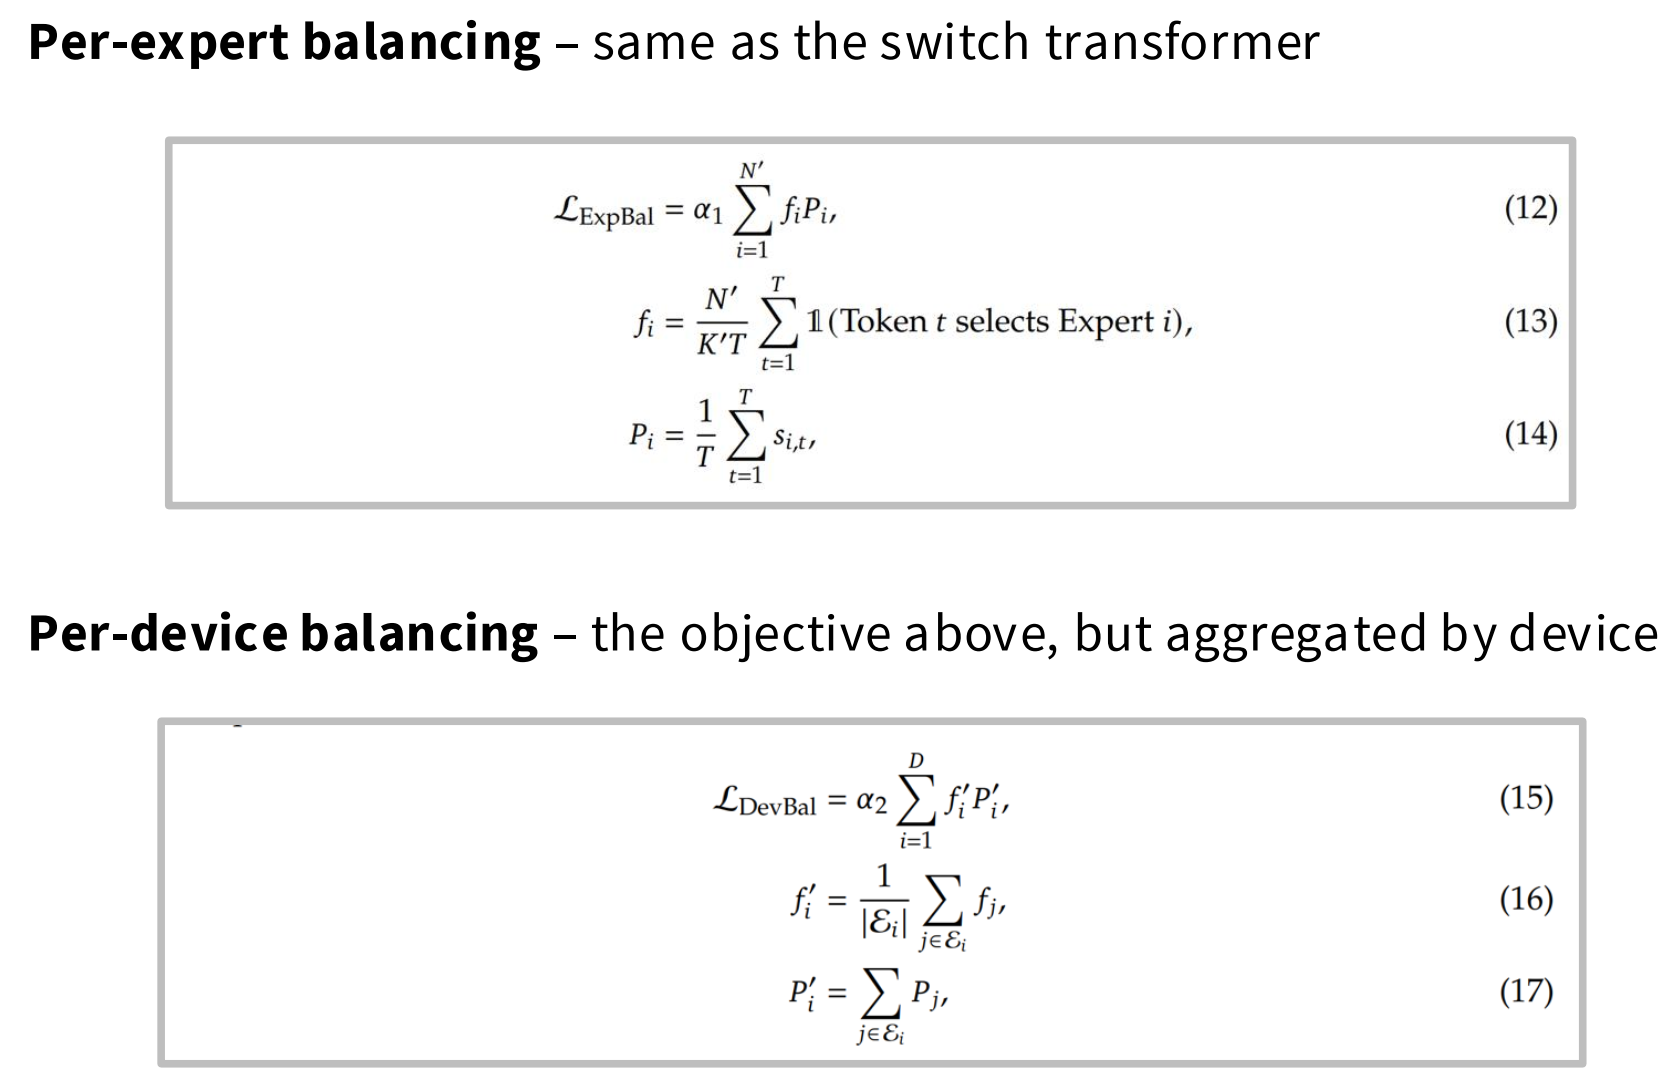
 - deepseek的创新，给每一个expert添加一个小的调整因子分数$b_i$,如果之前这个expert获得了较少的token，那么它会有更大的$b_i$值(每个batch之后进行调整)，后面就可以获得更多的token，这个b_i只是在expert的选择上起作用，并不会影响后期的token在expert中进行处理的参数。

### issues with MoEs- stability
 - 在softmax中可能会造成不稳定性，所以在MoEs中为了增加稳定性都使用float32
 - 还有可能使用一个辅助的z-loss
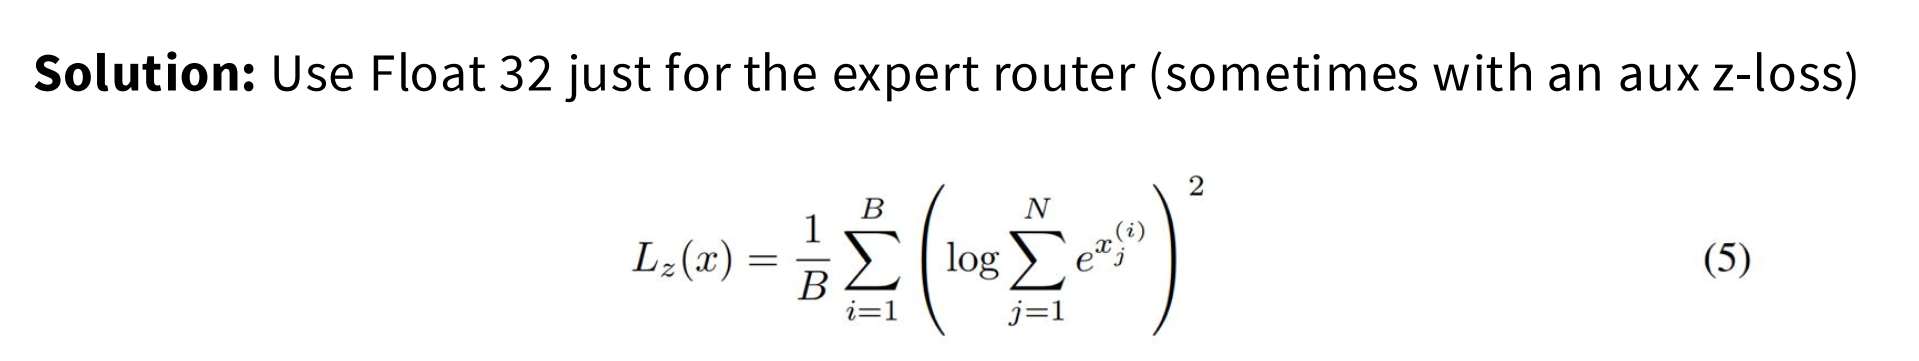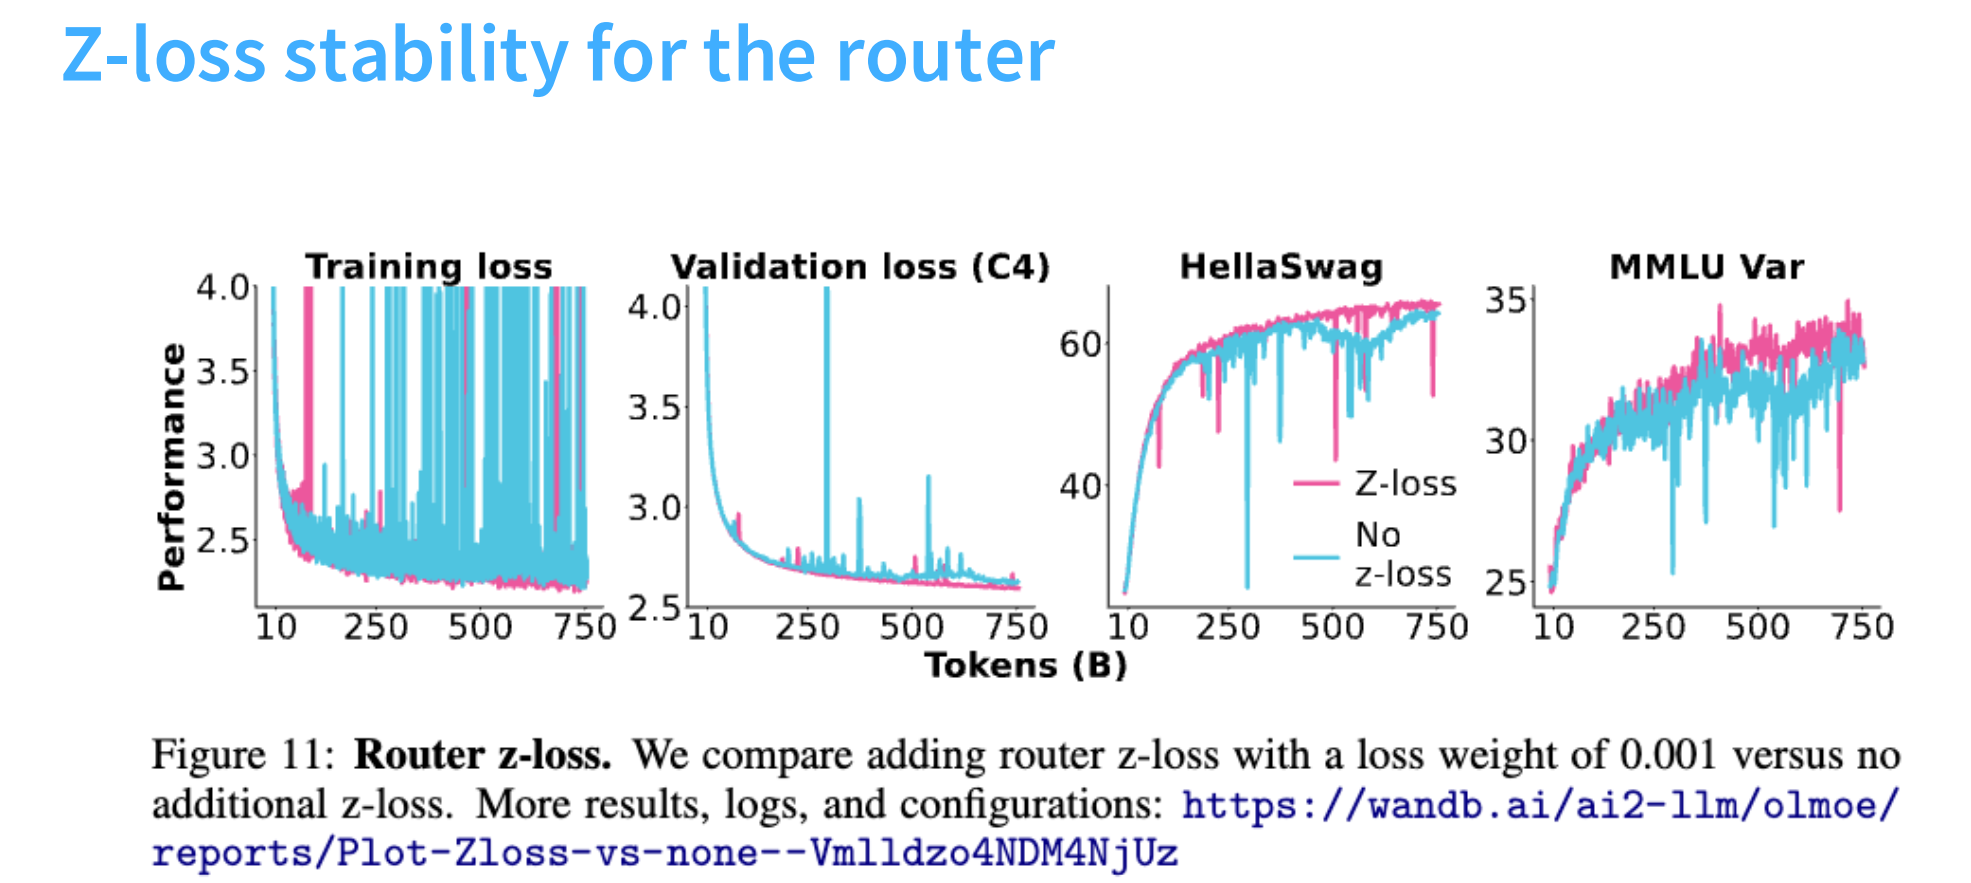

#### fine tuning
 - 在MoEs中会有过拟合的问题 
    —— 解决方法是
        - 不让MoE的每一层都是expert layer
        - 或者直接使用大量的数据解决这个问题

 - upcycling:用一个已经训练好的LM来初始化MoE,可以大大的降低成本
 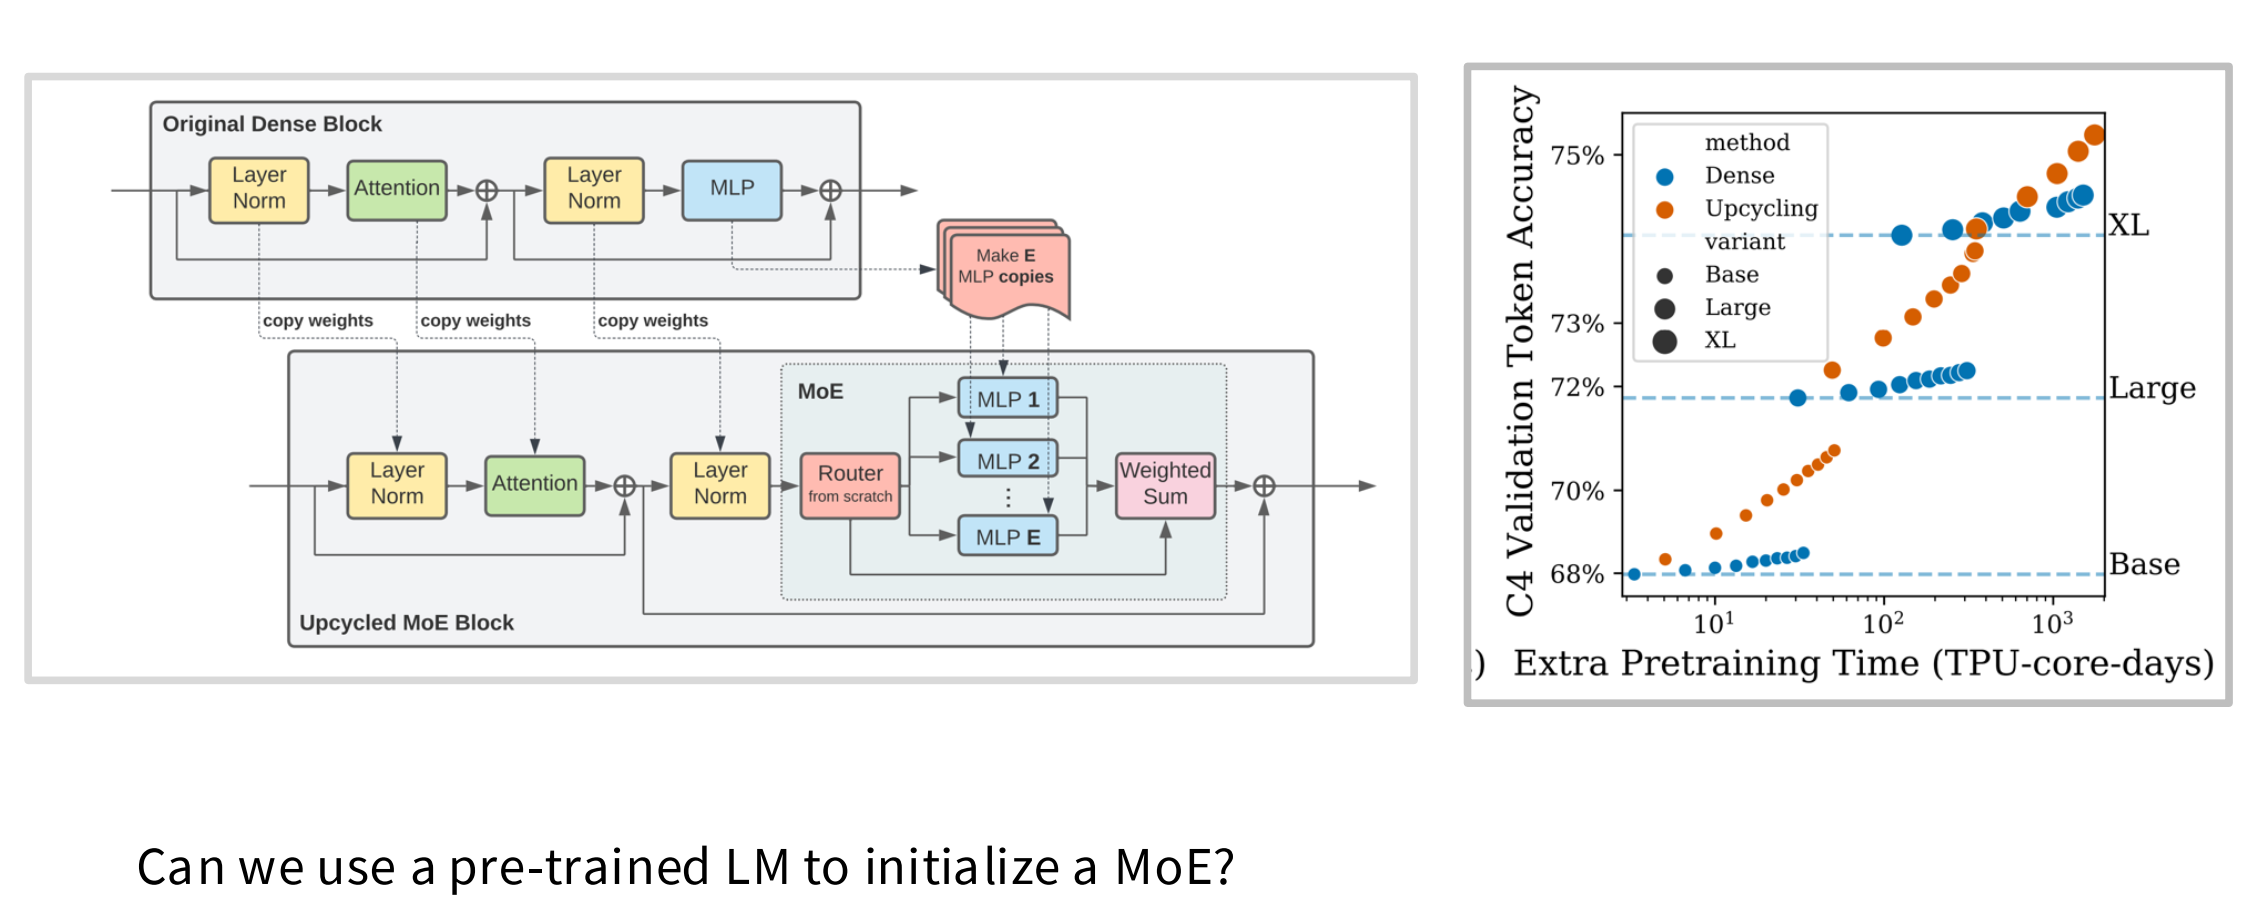

### 进一步对softmax和其他架构的升级
 - 在并行选择expert的时候考虑设备平衡的影响
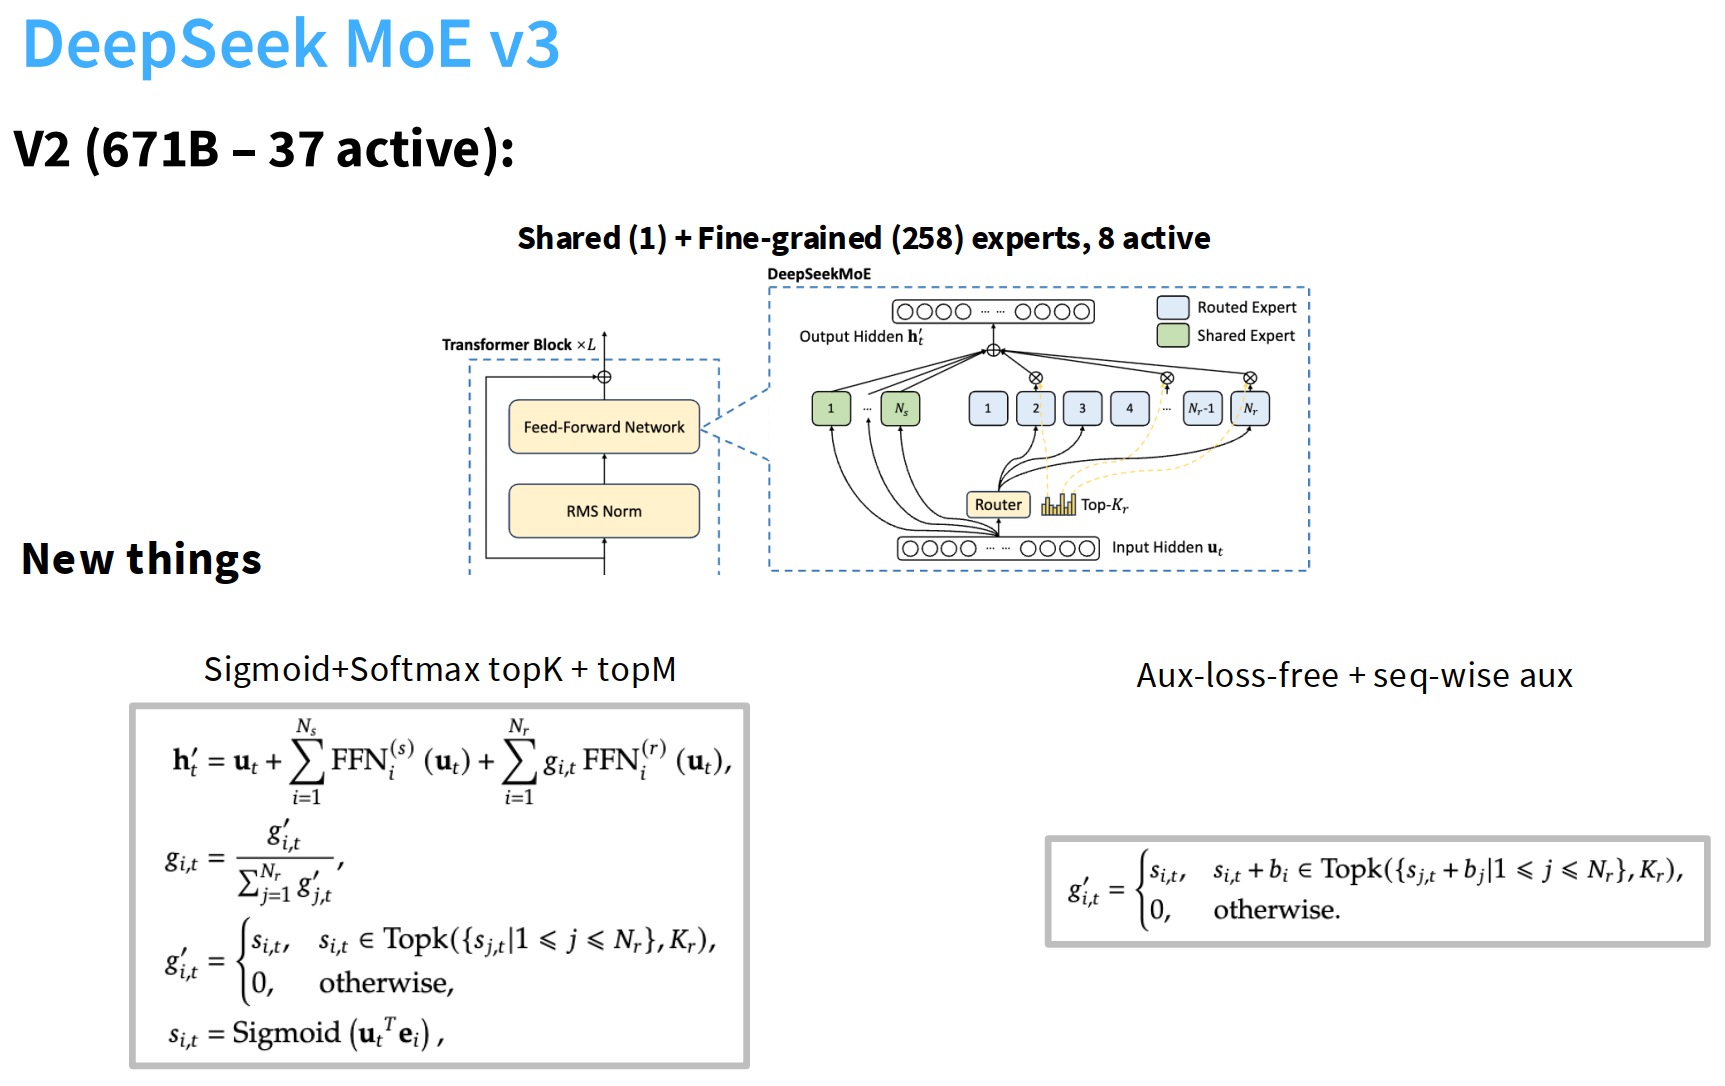

### deepseek模型的其他优化策略
 - 对multi head降低缓存的优化——不是将head的数量减少，而是将其投影到较低的维度，在计算结束之后再投影到原来的维度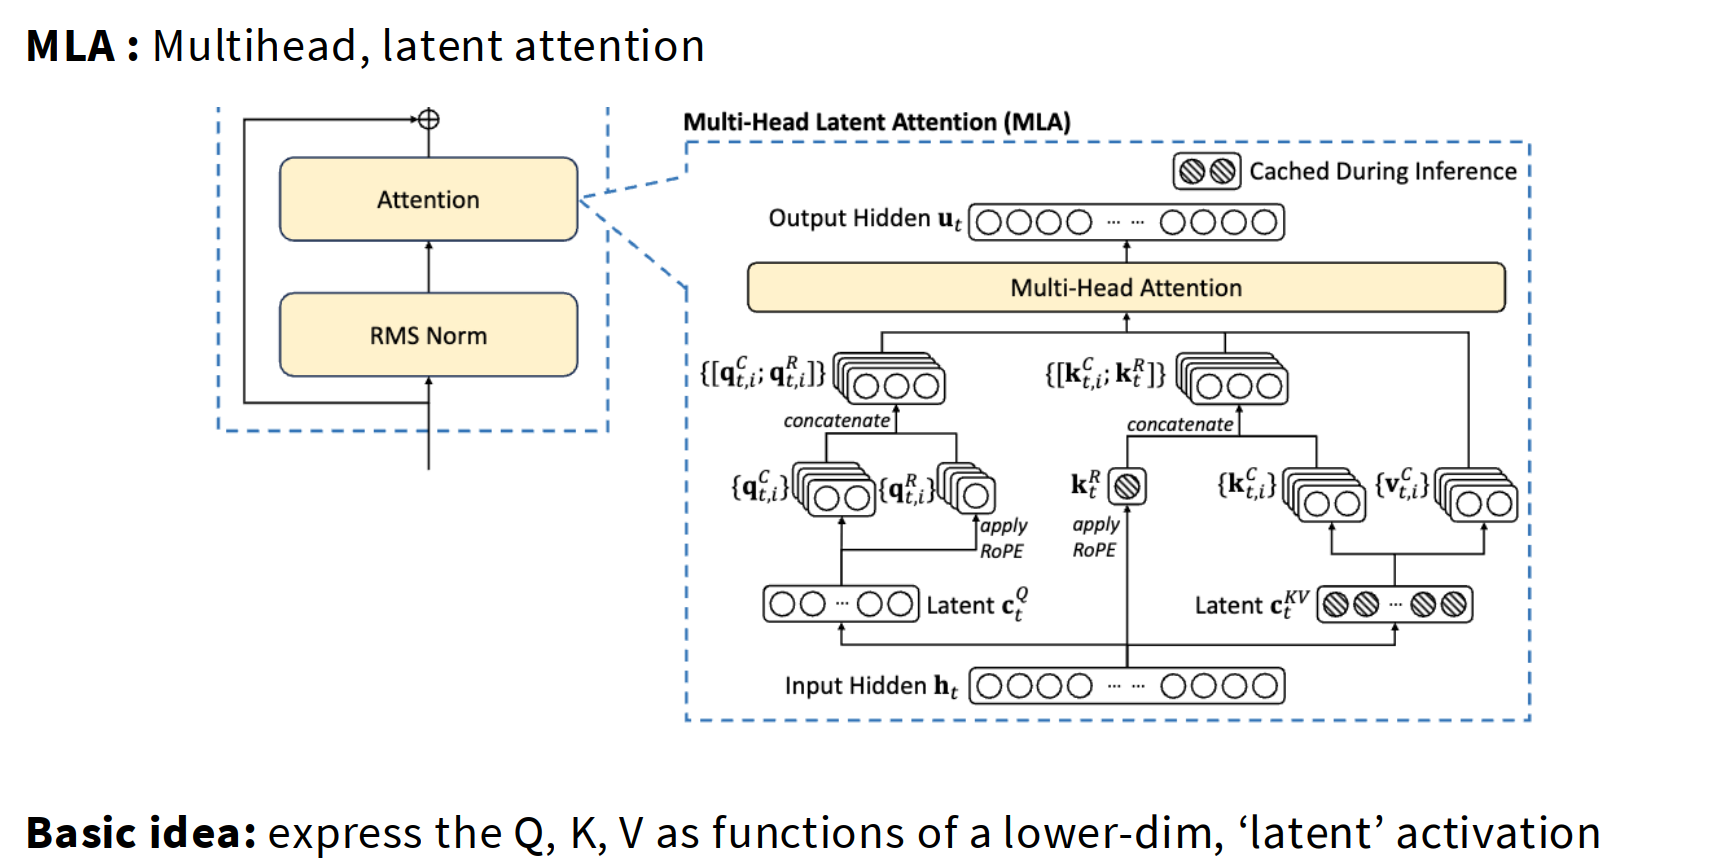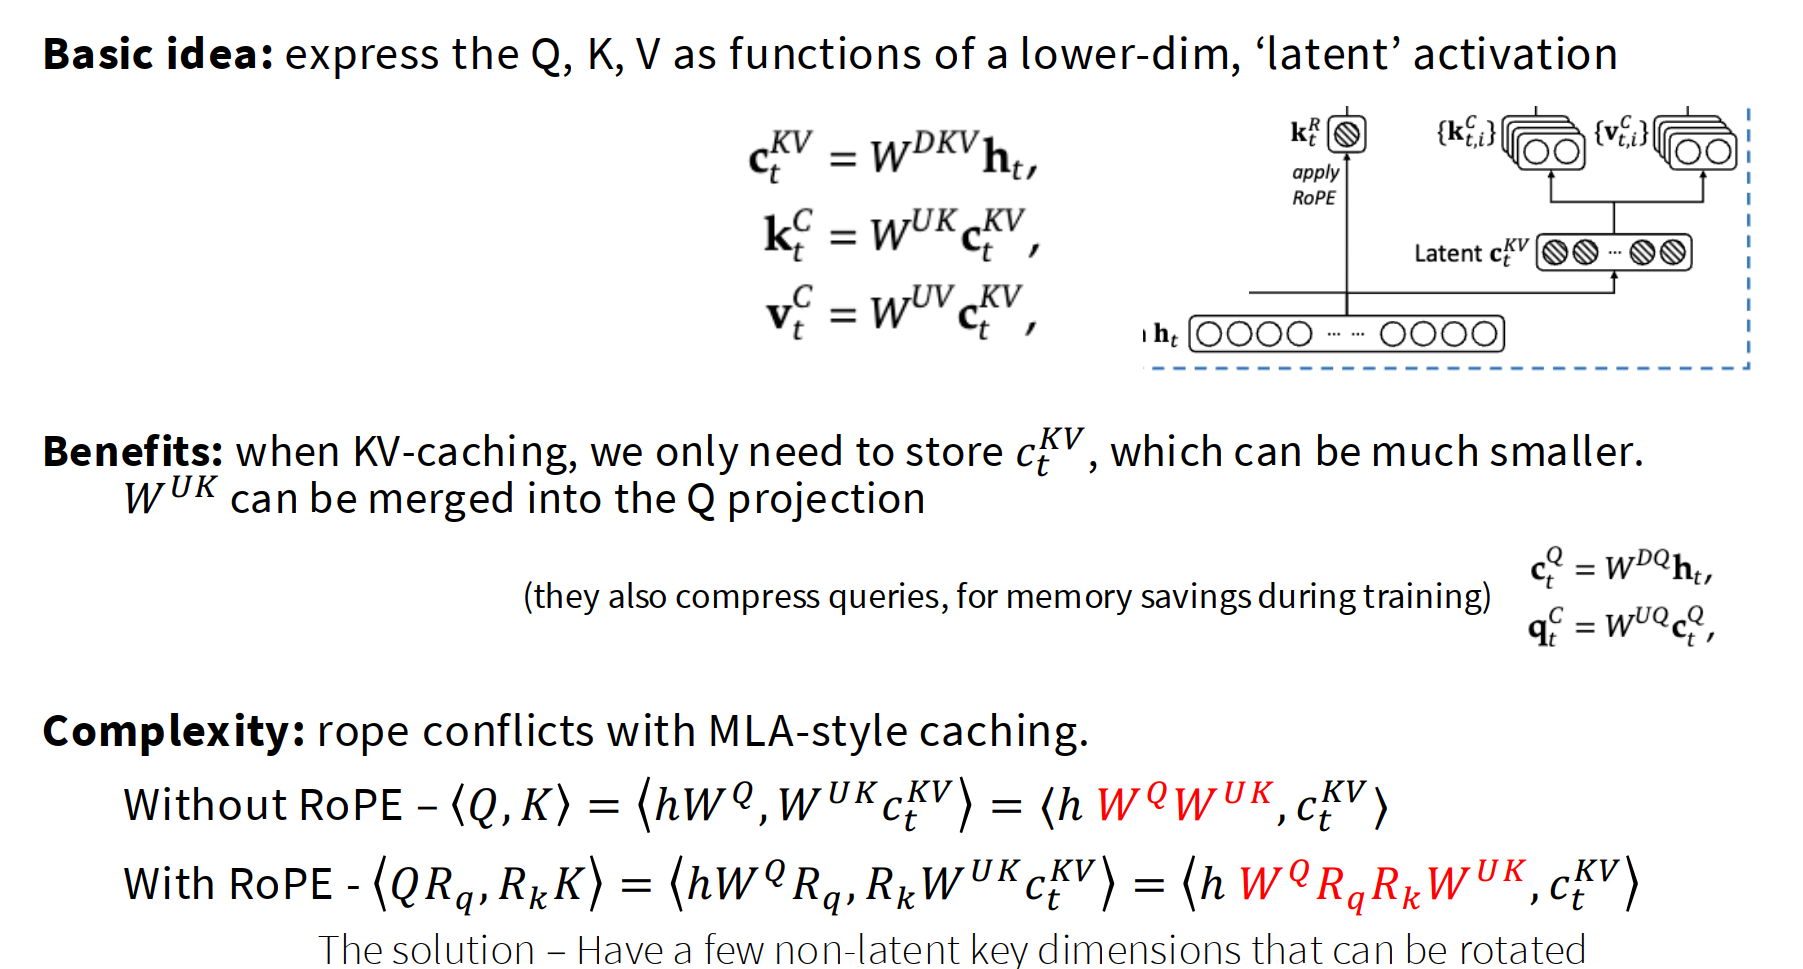